In [1]:
import openmc

In [2]:
TRISO = openmc.Model()

''' 
Materials 
'''

SiC = openmc.Material(1,name='SiC')
SiC.add_elements_from_formula('SiC')
SiC.set_density('g/cm3',3.2)

PyC = openmc.Material(2,name = 'PyC')
PyC.add_element('C',1)
PyC.set_density('g/cm3',1.9)

Carbon = openmc.Material(3,name = 'Carbon Buffer')
Carbon.add_element('C',1)
Carbon.set_density('g/cm3',1)

UCO = openmc.Material(4,name='Fuel')
UCO.add_element('U',3,enrichment=19.75,)
UCO.add_element('C',3)
UCO.add_element('O',2)
UCO.set_density('g/cm3',10.75)

TRISO.materials = openmc.Materials([SiC,PyC,Carbon,UCO])

/opt/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/material.py:790: UserWarning: A uranium enrichment of 19.75 was given for Material ID="4". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


In [10]:
'''
Geometry 
'''
#triso universe generation
outer_radius = 566.7e-4 #outer radius of OPyC
pf = .3
seed = 1
radii = [400e-4, 475e-4, 510e-4, 546.7e-4] #outer radii for fuel, buffer, ipyc, and SiC
spheres = [openmc.Sphere(r = radius) for radius in radii]
cells = [openmc.Cell(fill=UCO, region=-spheres[0]),
        openmc.Cell(fill = Carbon,region = +spheres[0] & -spheres[1]),
        openmc.Cell(fill = PyC, region = +spheres[1]&-spheres[2]),
        openmc.Cell(fill=SiC, region = +spheres[2]&-spheres[3]),
        openmc.Cell(fill = PyC, region = +spheres[3])]
triso_univ = openmc.Universe(cells = cells)

#compact generation and sphere packing
compact_radius,compact_height= outer_radius *15 , 1   #eyeball guess from pictures
compact_surface = openmc.ZCylinder(r = compact_radius)
top,bottom = openmc.ZPlane(z0 = compact_height/2,boundary_type ='reflective'), openmc.ZPlane(z0 = -compact_height/2,boundary_type = 'reflective')
compact_region =  -compact_surface & - top & + bottom
centroids = openmc.model.pack_spheres(radius = outer_radius,region=compact_region, pf = pf, seed = seed)

#bounding planes
outterhex = openmc.model.HexagonalPrism(edge_length=2*compact_radius,boundary_type = 'reflective',corner_radius=0)
hexagonal_compact = openmc.Cell(region = -outterhex &+bottom &-top&+compact_surface,fill=SiC)
cylinder_compact = openmc.Cell(region = compact_region)

#lattice generation 
trisos = [openmc.model.TRISO(outer_radius=outer_radius,fill = triso_univ, center=centroid) for centroid in centroids]
shape = (7,7,7)
lowerleft,upperright = cylinder_compact.region.bounding_box
pitch = (upperright-lowerleft)/shape
lattice = openmc.model.create_triso_lattice(trisos = trisos, lower_left=lowerleft, pitch=pitch,shape = shape,background=Carbon)
cylinder_compact.fill = lattice

universe = openmc.Universe(cells=[cylinder_compact,hexagonal_compact])
TRISO.geometry = openmc.Geometry(universe)


In [13]:
'''
Settings
'''
TRISO.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-compact_radius, -compact_radius, -compact_height], [compact_radius, compact_radius, compact_height],only_fissionable=True))
TRISO.settings.keff_trigger = {'type':'std_dev', 'threshold': .0009}
TRISO.settings.inactive = 0
TRISO.settings.batches = 5
TRISO.settings.trigger_max_batches = 10
TRISO.settings.particles = 1000

In [14]:
TRISO.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/Users/nglaser3/projects/OpenMC_FETs/TRISO_Model/statepoint.5.h5')

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

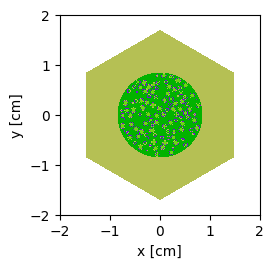

In [12]:
universe.plot(width=(4,4),color_by='material')

In [ ]:
TRISO.settings.keff_trigger = {'type':'std_dev', 'threshold': value}